# Clustering Case Study: Customer Segmentation with K-Means -  Tier 3
***
This case study is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by the `yhat` blog. Please feel free to refer to the post for additional information, and solutions.

Structure of the mini-project:

1. **Sourcing and loading**
    * Load the data
    * Explore the data


2. **Cleaning, transforming and visualizing**
    * Data Wrangling: Exercise Set 1
        - Creating a matrix with a binary indicator for whether they responded to a given offer
        - Ensure that in doing so, NAN values are dealt with appropriately
    

3. **Modelling** 
    * K-Means clustering: Exercise Sets 2 and 3
        - Choosing K: The Elbow method
        - Choosing K: The Silhouette method
        - Choosing K: The Gap statistic method
    
    * Visualizing clusters with PCA: Exercise Sets 4 and 5


4. **Conclusions and next steps**
    * Conclusions
    * Other clustering algorithms (Exercise Set 6)

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## 1. Sourcing and loading
### 1a. Load the data
The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)

C:\Users\amber\anaconda3\envs\bgM\lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


### 1b. Explore the data

In [3]:
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [4]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

C:\Users\amber\anaconda3\envs\bgM\lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## 2. Cleaning, transforming and visualizing
### 2a. Data Wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [5]:
# your turn
cust_offer_transactions = (df_transactions.merge(df_offers, how='left', on='offer_id')
                           .pivot_table(index='customer_name', columns='offer_id', values='n', fill_value=0)
                          )
pd.set_option('display.max_columns',50)
cust_offer_transactions

offer_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Adams,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0
Allen,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
Anderson,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
Bailey,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Baker,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Williams,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0
Wilson,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Wood,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [6]:
cust_offer_transactions.sum().sort_values(ascending=False)

offer_id
30    22
22    21
8     20
7     19
31    17
29    17
26    15
18    14
11    13
24    12
4     12
6     12
1     10
9     10
2     10
14     9
27     9
17     7
10     7
20     6
15     6
25     6
13     6
28     6
3      6
19     5
16     5
23     5
12     5
21     4
5      4
32     4
dtype: int64

## 3. Modelling 
### 3a. K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

#### 3ai. Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

**Hint:** the Elbow Method is discussed in part 2 of the Harvard Clustering lecture. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
    
    Ideally, low values, which indicate that data points are close to their cluster centers. However, it depends on the number of clusters. If, for example, the number of clusters is equal to the number of data points, then each point is its own cluster and $SS$ will be zero, but that doesn't help find clusters. For a fixed $k$, a smaller value for $SS$ are ideal.
    
    
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
    
    I tried a variety of random seeds, and find that the first obvious elbow tends to be the same, but that 'obvious' elbow is not really obvious. The plot of $SS$ vs $k$ looks almost like a line. Depending on the random starting state (which effects the convergence, per the Harvard lecture), the final cluster centers are different, therefor the inertias ($SS$) are different for given number of clusters and the elbow is not always obvious (very soft bend). The best value in k is the first value that significantly reduces the cluster-cluster $SS$. For this data, and random state 38, k=4 seems to be the best. Many of the other random seeds indicated k=3 was better.
</ul>
</div>

In [7]:
cust_offer_transactions.to_numpy()

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 1]], dtype=int64)

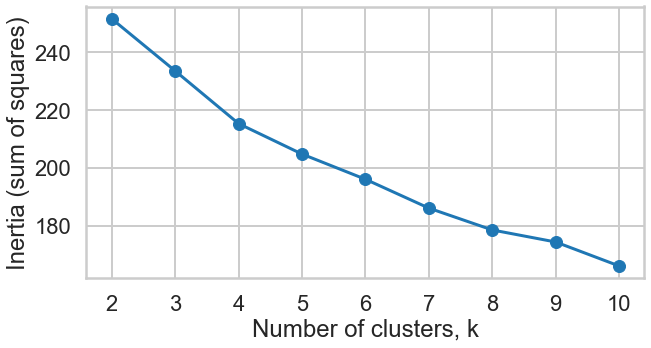

In [8]:
# your turn
from sklearn.cluster import KMeans
import numpy as np

x_cols = cust_offer_transactions.to_numpy()

ks = range(2,11)
inertias = []
ss_manual = []

for k in ks:
    model = KMeans(n_clusters=k, random_state=38)
    model.fit(x_cols)
    inertias.append(model.inertia_)
    ss_manual.append(np.sum((x_cols - model.cluster_centers_[model.predict(x_cols)])**2))

plt.rcParams["figure.figsize"] = (10,5)   
plt.plot(ks, inertias, '-o')
#plt.plot(ks, ss_manual, '-x')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia (sum of squares)')
plt.xticks(ks)
plt.show()

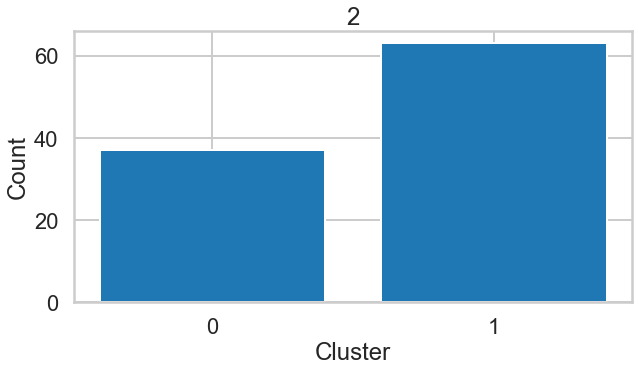

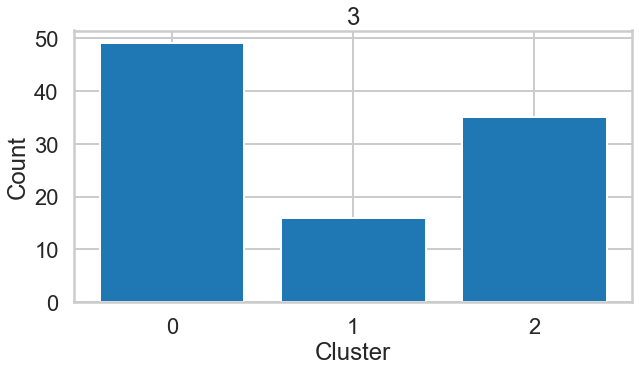

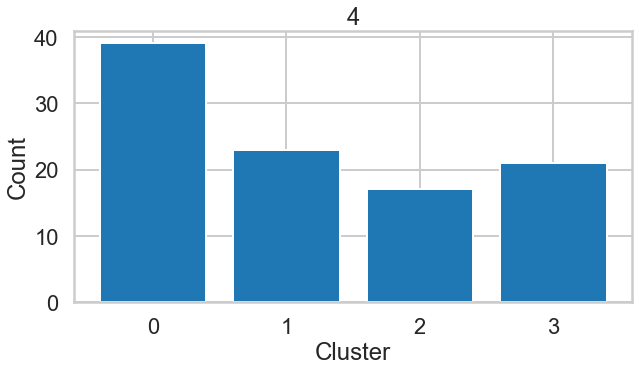

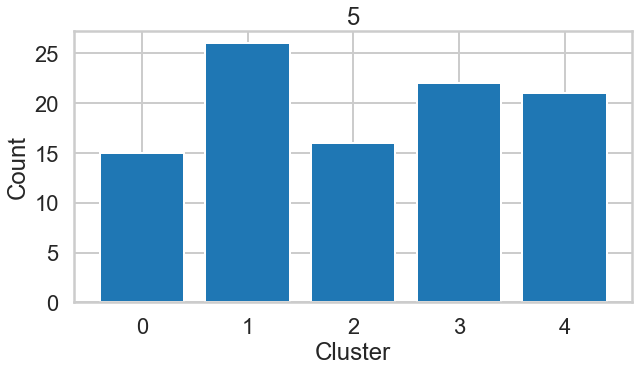

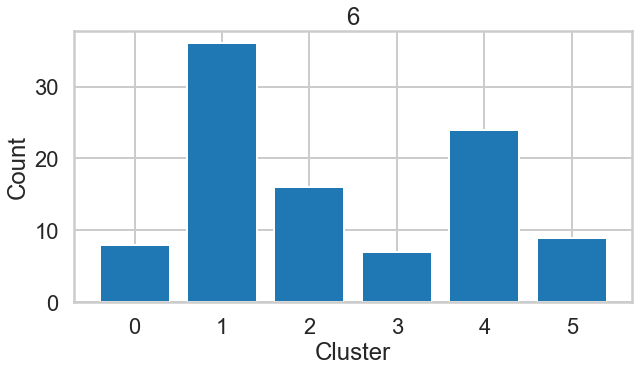

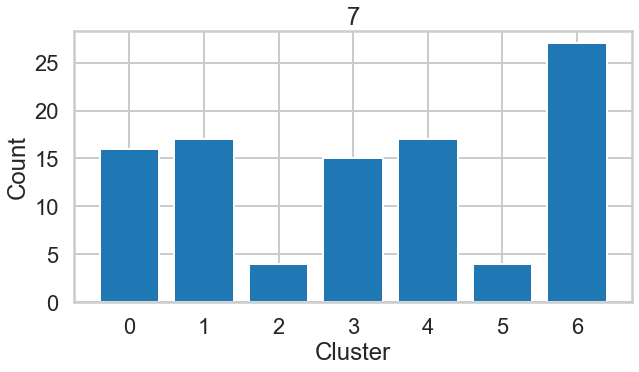

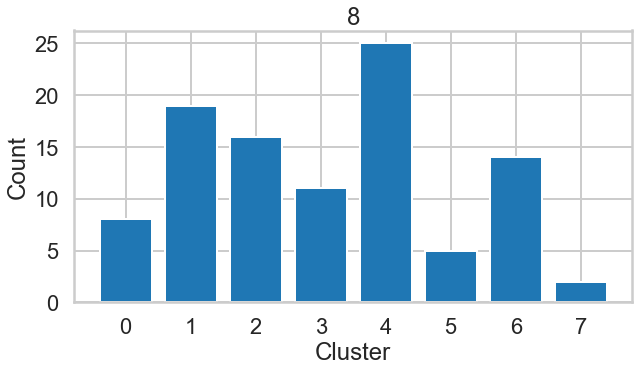

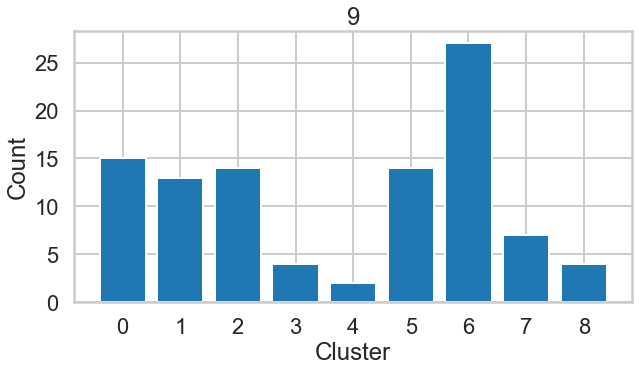

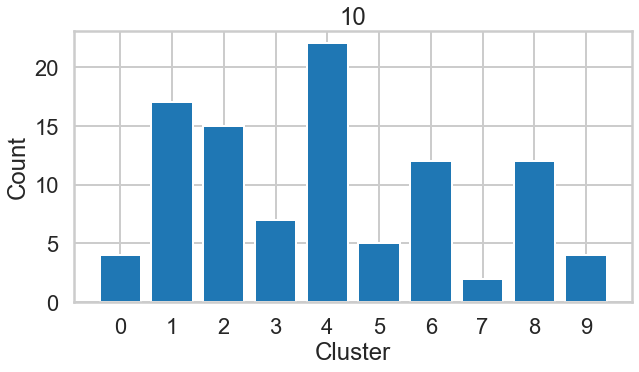

In [9]:
for k in ks:
    kmeans = KMeans(n_clusters = k, random_state=42)
    #plt.subplot(3,3,k-1)
    plt.bar(range(k), np.bincount(kmeans.fit_predict(x_cols)), align='center')
    plt.title(k)
    plt.xlabel('Cluster')
    plt.ylabel('Count')
    plt.xticks(range(k))
    plt.show()

#### 3aii. Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

**Hint**: Scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
    
    As before, there isn't an obvious value of optimal k and it's dependent on the initialization/random seed. I played around with a visual of PCA ahead of time and it seems that in the sparce un-reduced dimension space, there aren't obvioius cluster structures. There seems to be some optimazation with k=4, but it's not entirely clear, as the silhouette score doesn't have any smoothness to it and thus only has local (rather than global) maxima.
    
</div>

In [10]:
cust_offer_transactions

offer_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Adams,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0
Allen,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
Anderson,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
Bailey,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Baker,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Williams,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0
Wilson,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Wood,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


For n_clusters = 2 The average silhouette_score is : 0.09174871508750351
For n_clusters = 3 The average silhouette_score is : 0.10433917596822187
For n_clusters = 4 The average silhouette_score is : 0.12613995539349154
For n_clusters = 5 The average silhouette_score is : 0.0975982481334106
For n_clusters = 6 The average silhouette_score is : 0.12642009843375024
For n_clusters = 7 The average silhouette_score is : 0.13059306288368167
For n_clusters = 8 The average silhouette_score is : 0.1369614780609198
For n_clusters = 9 The average silhouette_score is : 0.1361862445492786
For n_clusters = 10 The average silhouette_score is : 0.11534522234759662


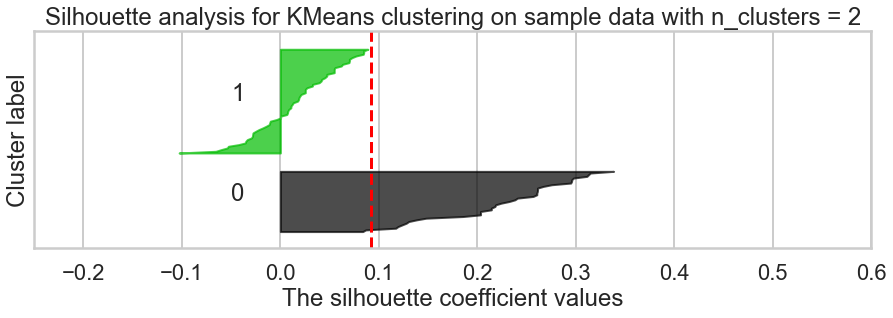

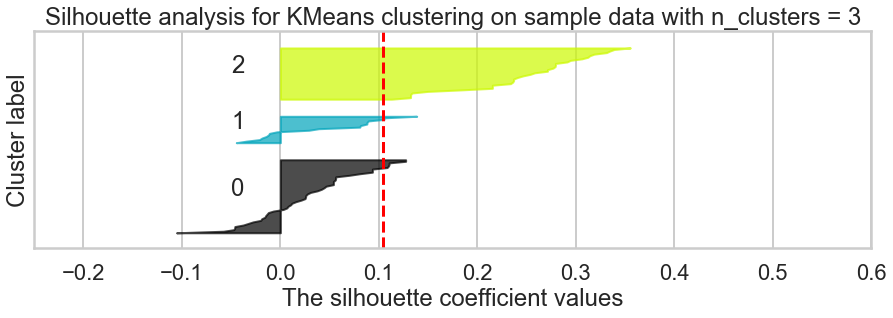

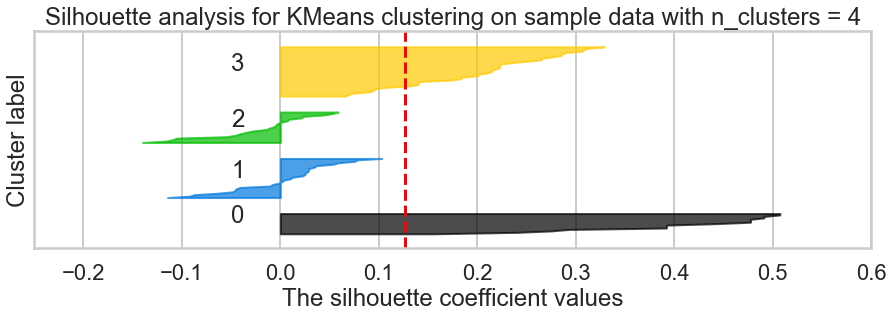

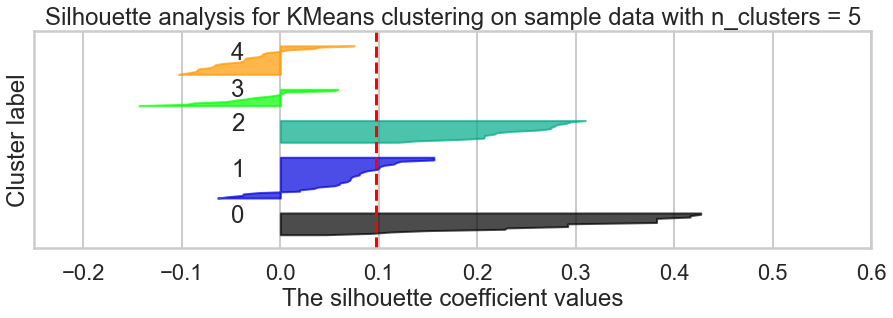

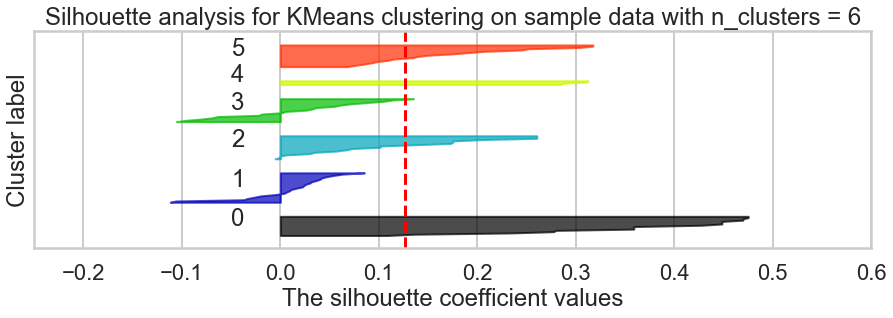

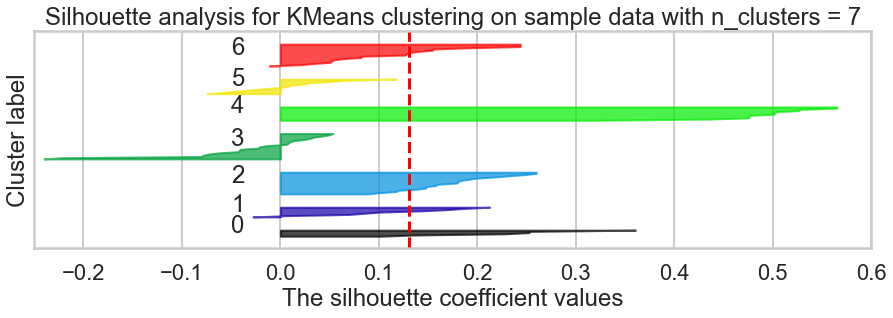

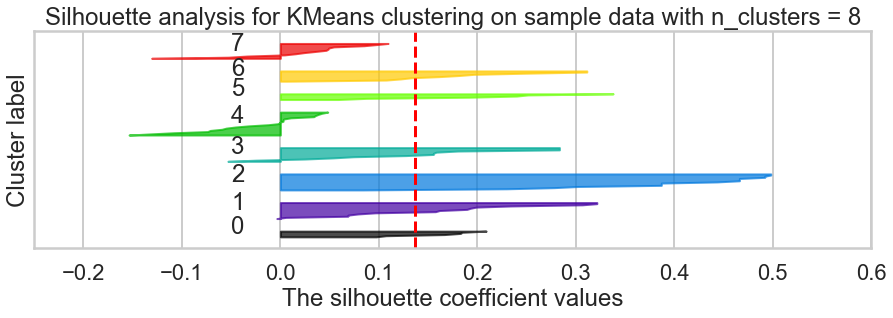

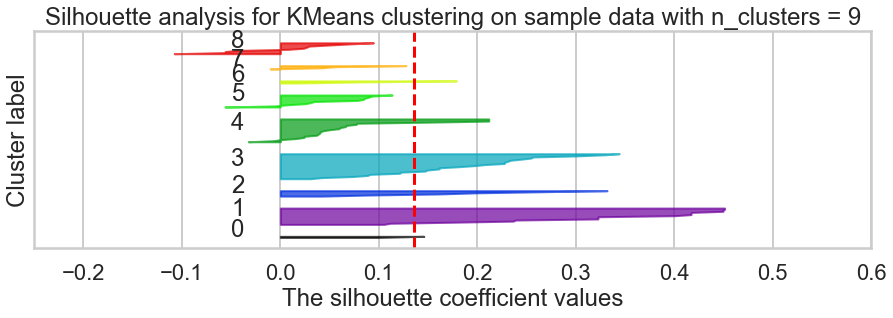

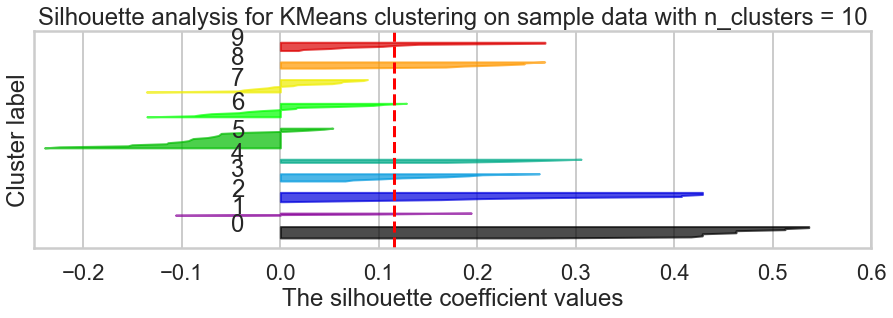

In [12]:
# Your turn.
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
silhouette_avgs=[]
for n_clusters in range(2, 11):
    
    fig, ax = plt.subplots(1, 1) # Create a subplot with 1 row and 2 columns
    fig.set_size_inches(15, 4)

    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.25, 0.6])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(x_cols) + (n_clusters + 1) * 10])

    # Initialize the kmmodel with n_clusters value and a random generator
    # seed for reproducibility.
    kmmodel = KMeans(n_clusters=n_clusters, random_state=38)
    cluster_labels = kmmodel.fit_predict(x_cols)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters


    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    silhouette_avgs.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    #ax.set_title("The silhouette plot for the various clusters.")
    ax.set_title(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters))
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
    


    

plt.show()

Text(0, 0.5, 'Average silhoestte score')

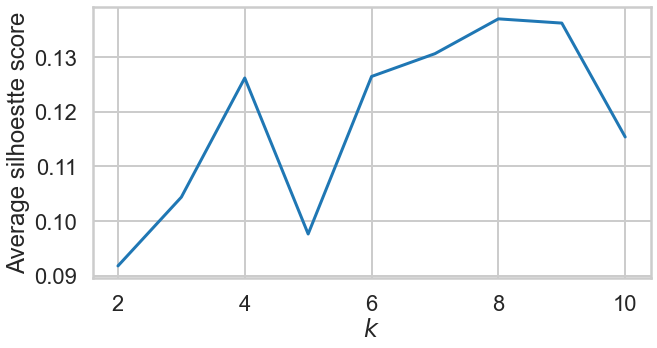

In [13]:
plt.plot(ks, silhouette_avgs)
plt.xlabel("$k$")
plt.ylabel("Average silhoestte score")

For n_clusters = 2 The average silhouette_score is : 0.09174871508750351
For n_clusters = 3 The average silhouette_score is : 0.10433917596822187
For n_clusters = 4 The average silhouette_score is : 0.12613995539349154
For n_clusters = 5 The average silhouette_score is : 0.0975982481334106
For n_clusters = 6 The average silhouette_score is : 0.12642009843375024
For n_clusters = 7 The average silhouette_score is : 0.13059306288368167
For n_clusters = 8 The average silhouette_score is : 0.1369614780609198
For n_clusters = 9 The average silhouette_score is : 0.1361862445492786
For n_clusters = 10 The average silhouette_score is : 0.11534522234759662


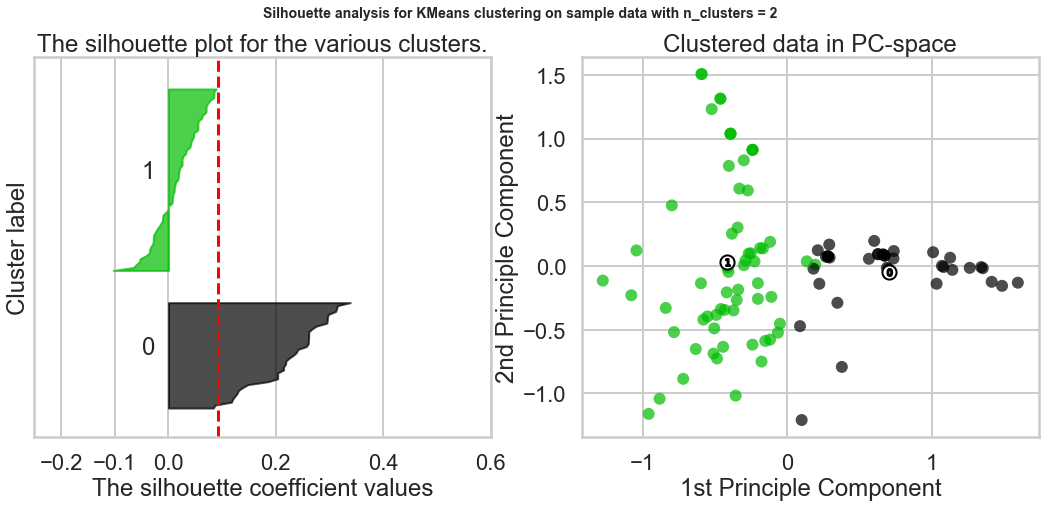

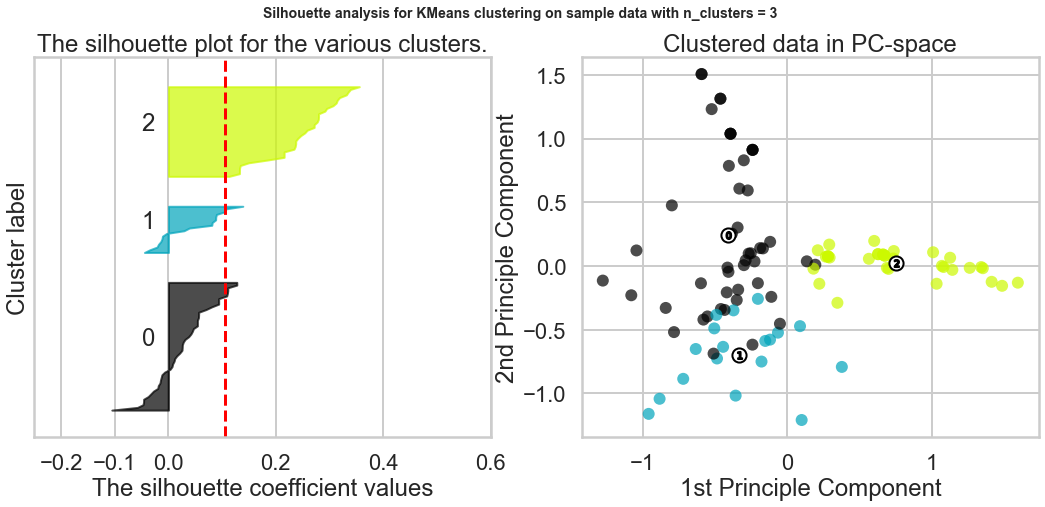

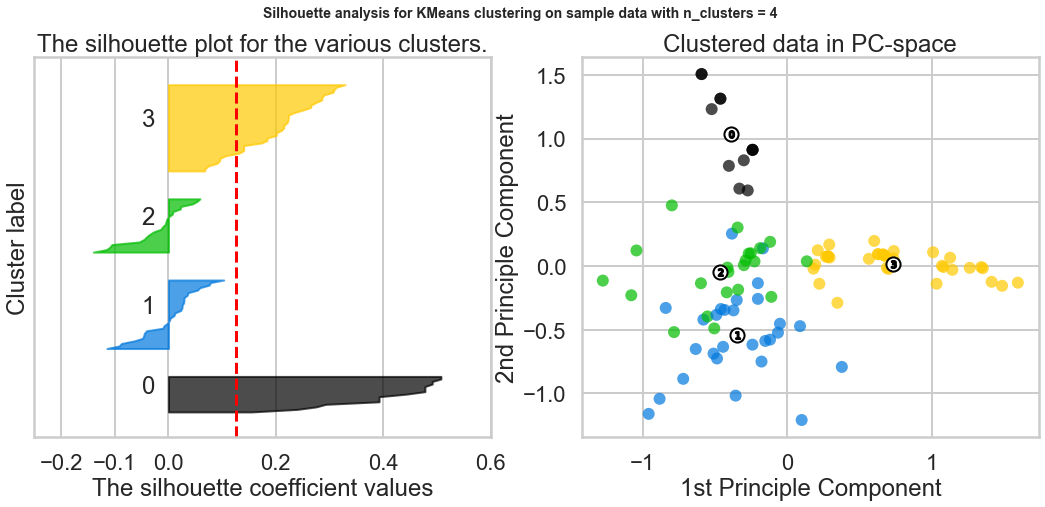

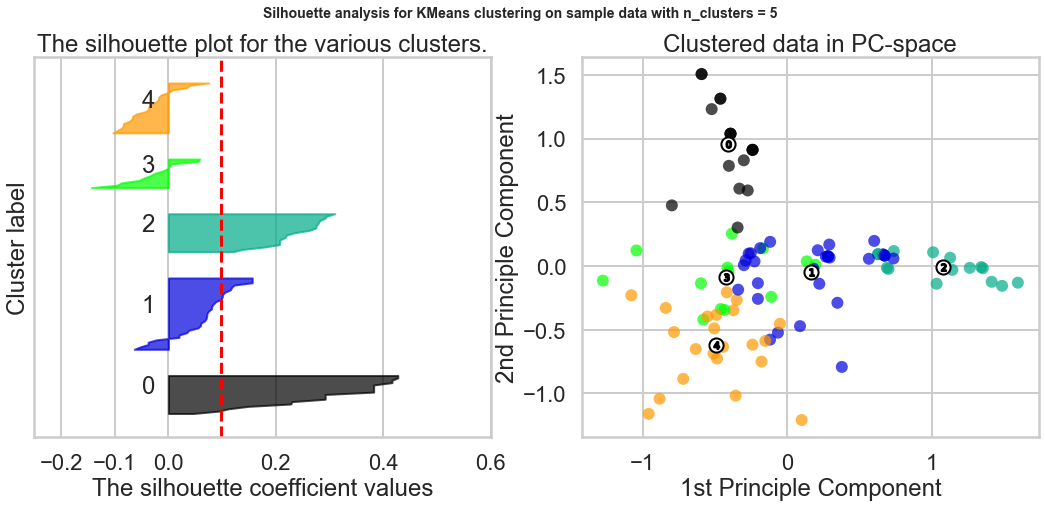

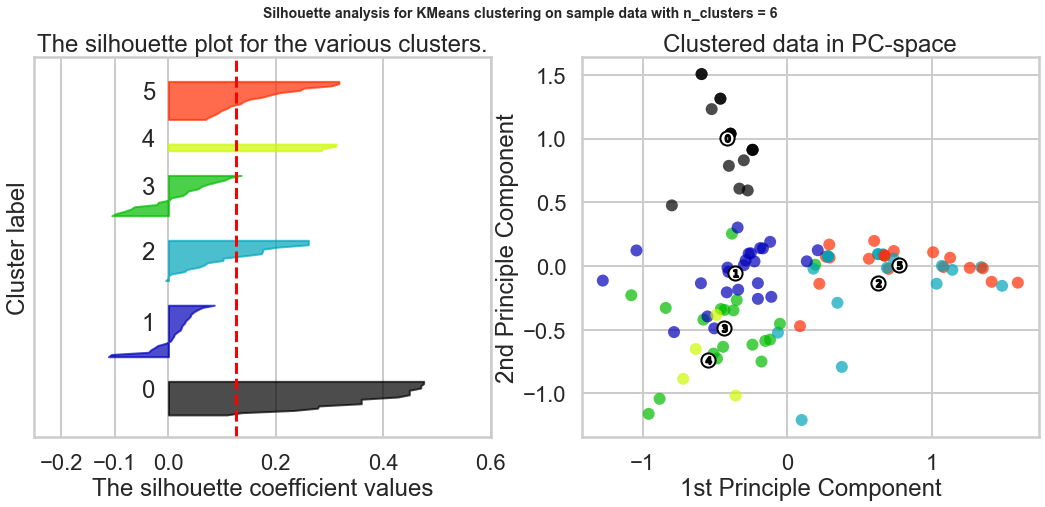

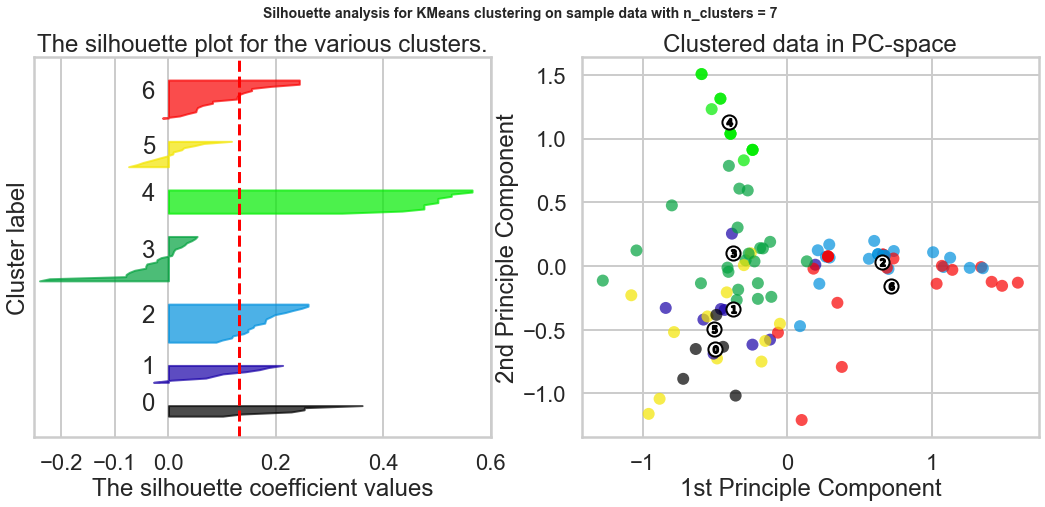

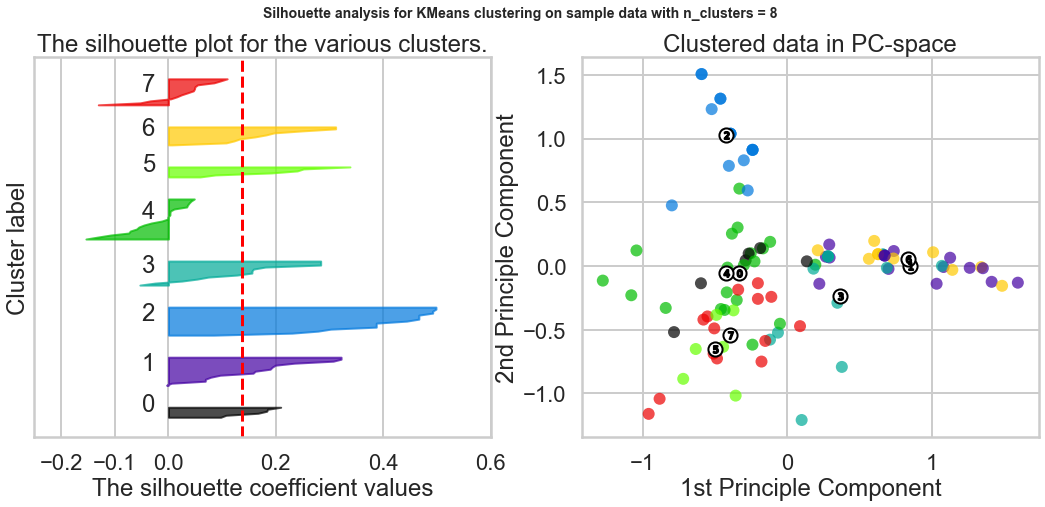

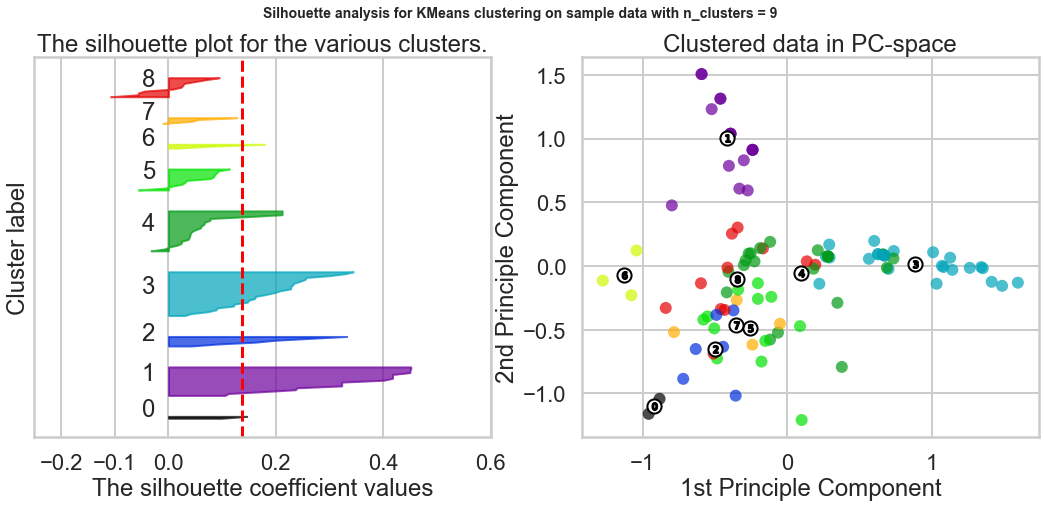

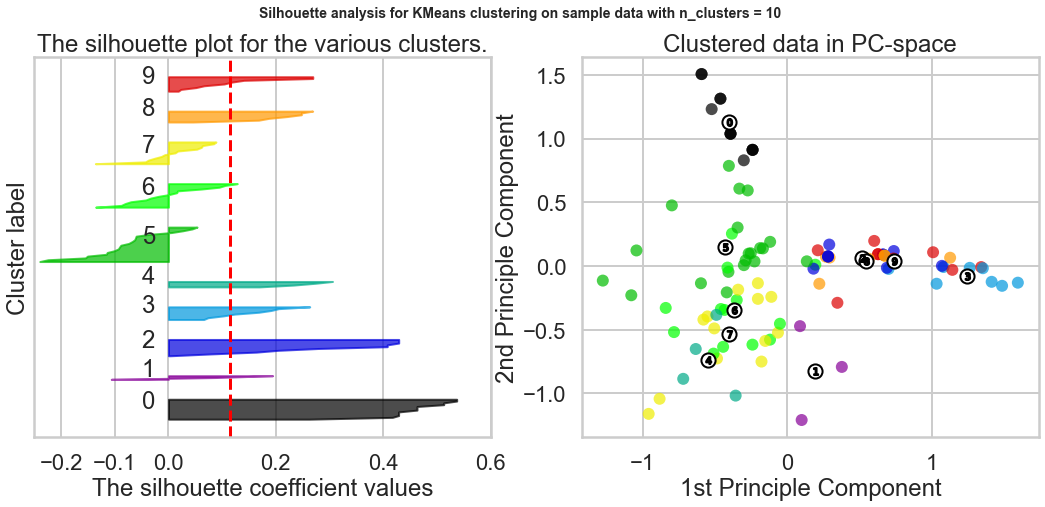

In [14]:
# Your turn.
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.cm as cm

# Perform PCA for dimension reduction and easier visualization
pca = PCA(n_components=2)
pca.fit(x_cols)
pca_df = pd.DataFrame(pca.transform(x_cols))

for n_clusters in range(2, 11):
    
    fig, (ax1, ax2) = plt.subplots(1, 2) # Create a subplot with 1 row and 2 columns
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.25, 0.6])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(x_cols) + (n_clusters + 1) * 10])

    # Initialize the kmmodel with n_clusters value and a random generator
    # seed for reproducibility.
    kmmodel = KMeans(n_clusters=n_clusters, random_state=38)
    cluster_labels = kmmodel.fit_predict(x_cols)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, -0.1, 0, 0.2, 0.4, 0.6])


    
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        #x_cols[:, 0], x_cols[:, 1],
       # x_cols[0], x_cols[1], 
        pca_df[0], pca_df[1],
       # cust_offer_transactions[0], cust_offer_transactions[1],
        lw=0, 
        alpha=0.7, 
        c=colors, 
        edgecolor='k'
    )

    # Labeling the clusters
    centers = kmmodel.cluster_centers_
    # pca.transform(centers[])
    centers_pca = pd.DataFrame(pca.transform(centers))
    
    # Draw white circles at cluster centers
    ax2.scatter(#centers[:, 0], centers[:, 1], 
                pca.transform(centers)[:, 0], pca.transform(centers)[:, 1],
                marker='o',
                c="white", 
                alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(pca.transform(centers)):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("Clustered data in PC-space")
    ax2.set_xlabel("1st Principle Component")
    ax2.set_ylabel("2nd Principle Component")
    
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters), fontsize=14, fontweight='bold')
plt.show()

#### 3aiii.  Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

#### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

**Hint:** See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

### 3b. Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

**Hint:** PCA was discussed in the previous subunit. If you need help with it, consult [this useful article](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c) and [this visual explanation](http://setosa.io/ev/principal-component-analysis/). 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
    
    Check
    
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
    
    Check
    
<li> Plot a scatterplot of the `x` vs `y` columns
    
    Check
    
<li> Color-code points differently based on cluster ID
    
    Check
    
<li> How do the clusters look? 
    
    The clusters look okay - in the space of principle components 1 and 2, there seem to be 3 obvious clusters (this doesn't surprise me too much, as some evidence pointed to this earlier, with a soft elbow at k=3 for my first choice of random state = 42). I think it might make more sense to do the PCA on the entire X data frame BEFORE finding the clusters instead of finding the clusters and then tranforming into the PCA space. I suspect this would yeild a more ovbious choice of k=3 clusters. 
    
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
    
    Cluster 0 is customers who prefer pinot noir. Cluster 1 is customers who prefer sparkling wines, champagne and proseco. Cluster 2 are the average customers, who have a variety of standard flavor and price preferences, while cluster 4 are the discount seekers who perfer a low quanity (min_qty of 6).
    
</div>

In [15]:
# Get the model for selected k = 4 (my choice) and same random state as before
km4_model = KMeans(n_clusters=4, random_state=38).fit(x_cols)
cluster_id = km4_model.labels_

# reduce the dimensionality of clustering data to 2 components
pca = PCA(n_components=2)
x, y = zip(*pca.fit_transform(x_cols))
# pca.fit(x_cols)
#pca_df = pd.DataFrame(pca.transform(x_cols))

pca_df = pd.DataFrame({'cust_name':cust_offer_transactions.index, 'cluster_label':cluster_id, 'x':x, 'y':y})
pca_df

,cust_name,cluster_label,x,y
0,Adams,3,1.007580,0.108215
1,Allen,2,-0.287539,0.044715
2,Anderson,0,-0.392032,1.038391
3,Bailey,3,0.699477,-0.022542
4,Baker,1,0.088183,-0.471695
...,...,...,...,...
95,Williams,1,-0.151666,-0.587844
96,Wilson,3,0.688224,-0.013688
97,Wood,2,-0.551215,-0.395670
98,Wright,1,-0.489805,-0.383307


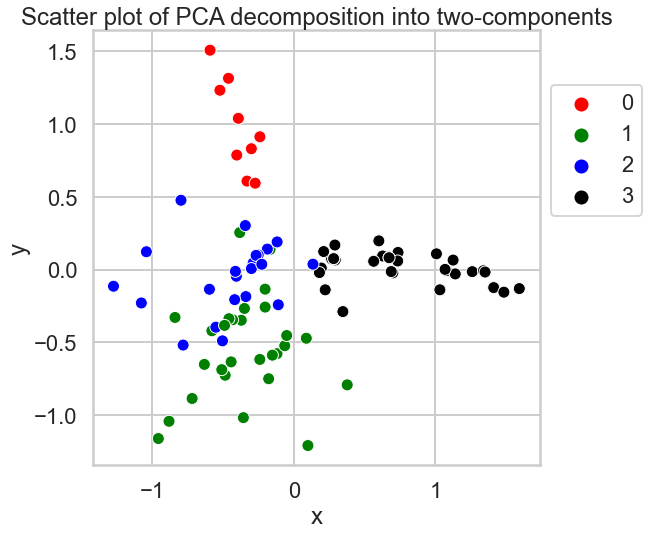

In [16]:
_, ax = plt.subplots(1,1,figsize=(8,8))

basic_palette = ['red', 'green', 'blue', 'black']
sns.scatterplot(data = pca_df, x='x',y='y', hue='cluster_label', palette = basic_palette, ax=ax)
plt.legend(loc='upper left', bbox_to_anchor=(1.0,0.9))
ax.set_title('Scatter plot of PCA decomposition into two-components')
plt.show()

<IPython.core.display.Javascript object>


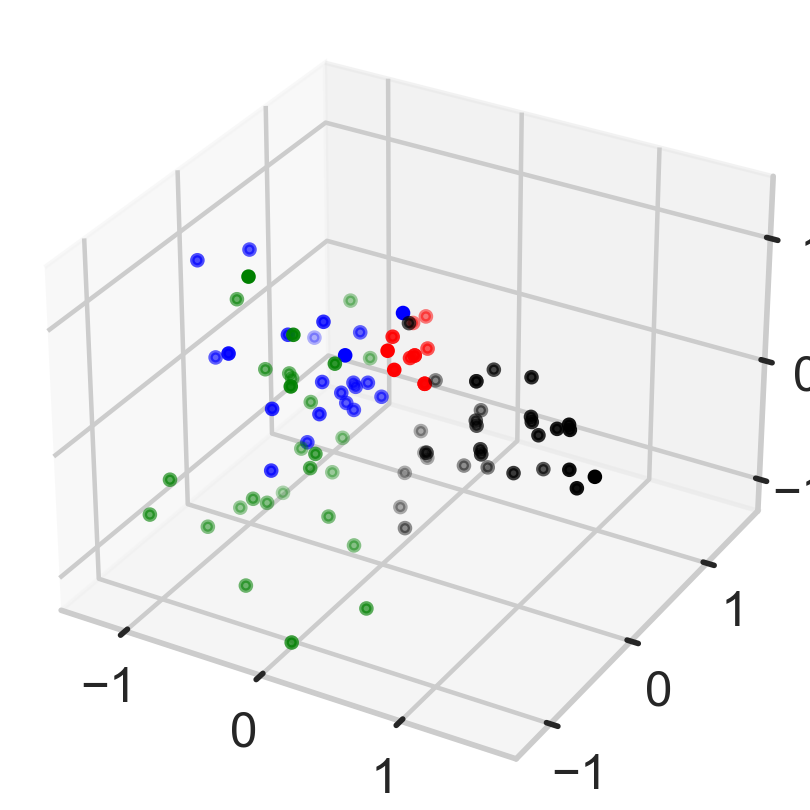

C:\Users\amber\AppData\Local\Temp\ipykernel_25284\1990523721.py:14: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


In [17]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

# reduce the dimensionality of clustering data to 2 components
pca3 = PCA(n_components=3)
x, y, z = zip(*pca3.fit_transform(x_cols))
# pca.fit(x_cols)
#pca_df = pd.DataFrame(pca.transform(x_cols))

pca3_df = pd.DataFrame({'cust_name':cust_offer_transactions.index, 'cluster_label':cluster_id, 'x':x, 'y':y, 'z':z})
pca3_df

fig = plt.figure(figsize=(5,5))
ax = Axes3D(fig)

basic_palette = ['red', 'green', 'blue', 'black']

for c_id, color in zip([0,1,2,3],basic_palette):
    data = pca3_df[pca3_df.cluster_label == c_id]
    ax.scatter(data.x, data.y, data.z, color=color)
plt.show()

# sns.scatterplot(data = pca_df, x='x',y='y', hue='cluster_label', palette = basic_palette, ax=ax)
# plt.legend(loc='upper left', bbox_to_anchor=(1.0,0.9))
# ax.set_title('Scatter plot of PCA decomposition into two-components')
# plt.show()

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<IPython.core.display.Javascript object>


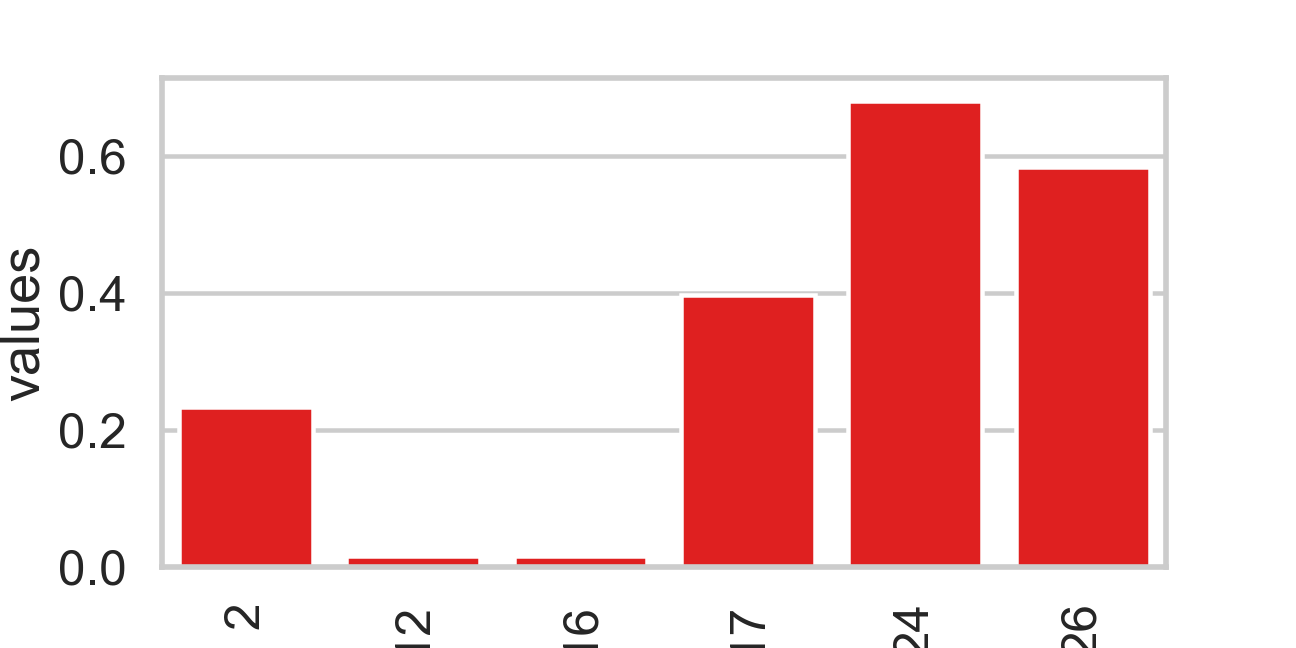

    offer_id   campaign    varietal  min_qty  discount      origin  past_peak
1          2    January  Pinot Noir       72        17      France      False
11        12        May    Prosecco       72        83   Australia      False
15        16       June      Merlot       72        88  California      False
16        17       July  Pinot Noir       12        47     Germany      False
23        24  September  Pinot Noir        6        34       Italy      False
25        26    October  Pinot Noir      144        83   Australia      False


<IPython.core.display.Javascript object>


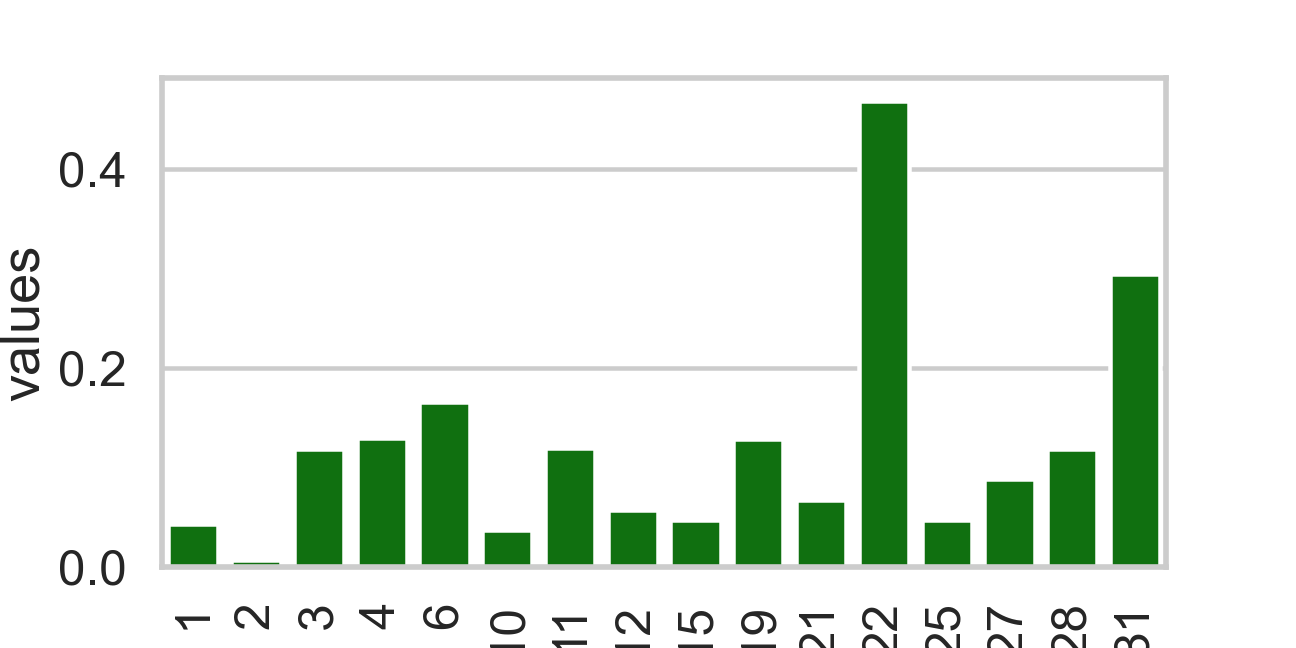

    offer_id  campaign            varietal  min_qty  discount       origin  \
0          1   January              Malbec       72        56       France   
1          2   January          Pinot Noir       72        17       France   
2          3  February           Espumante      144        32       Oregon   
3          4  February           Champagne       72        48       France   
5          6     March            Prosecco      144        86        Chile   
9         10     April            Prosecco       72        52   California   
10        11       May           Champagne       72        85       France   
11        12       May            Prosecco       72        83    Australia   
14        15      June  Cabernet Sauvignon      144        19        Italy   
18        19      July           Champagne       12        66      Germany   
20        21    August           Champagne       12        50   California   
21        22    August           Champagne       72        63   

<IPython.core.display.Javascript object>


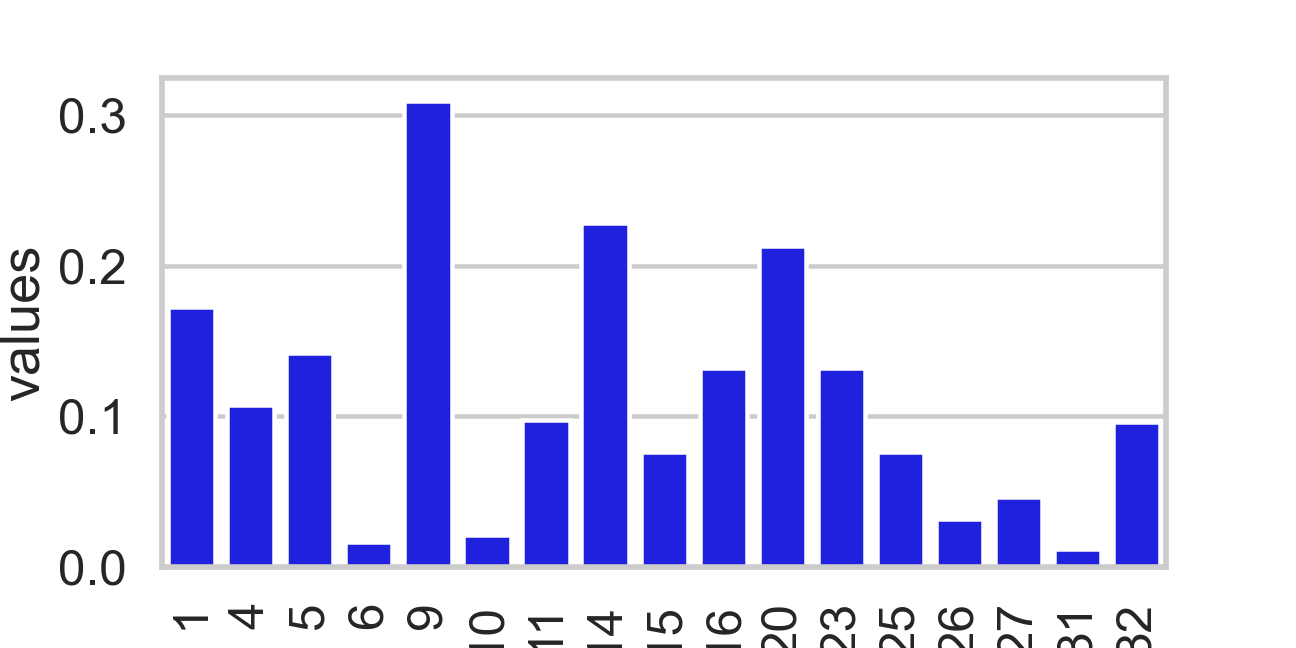

    offer_id   campaign            varietal  min_qty  discount        origin  \
0          1    January              Malbec       72        56        France   
3          4   February           Champagne       72        48        France   
4          5   February  Cabernet Sauvignon      144        44   New Zealand   
5          6      March            Prosecco      144        86         Chile   
8          9      April          Chardonnay      144        57         Chile   
9         10      April            Prosecco       72        52    California   
10        11        May           Champagne       72        85        France   
13        14       June              Merlot       72        64         Chile   
14        15       June  Cabernet Sauvignon      144        19         Italy   
15        16       June              Merlot       72        88    California   
19        20     August  Cabernet Sauvignon       72        82         Italy   
22        23  September          Chardon

<IPython.core.display.Javascript object>


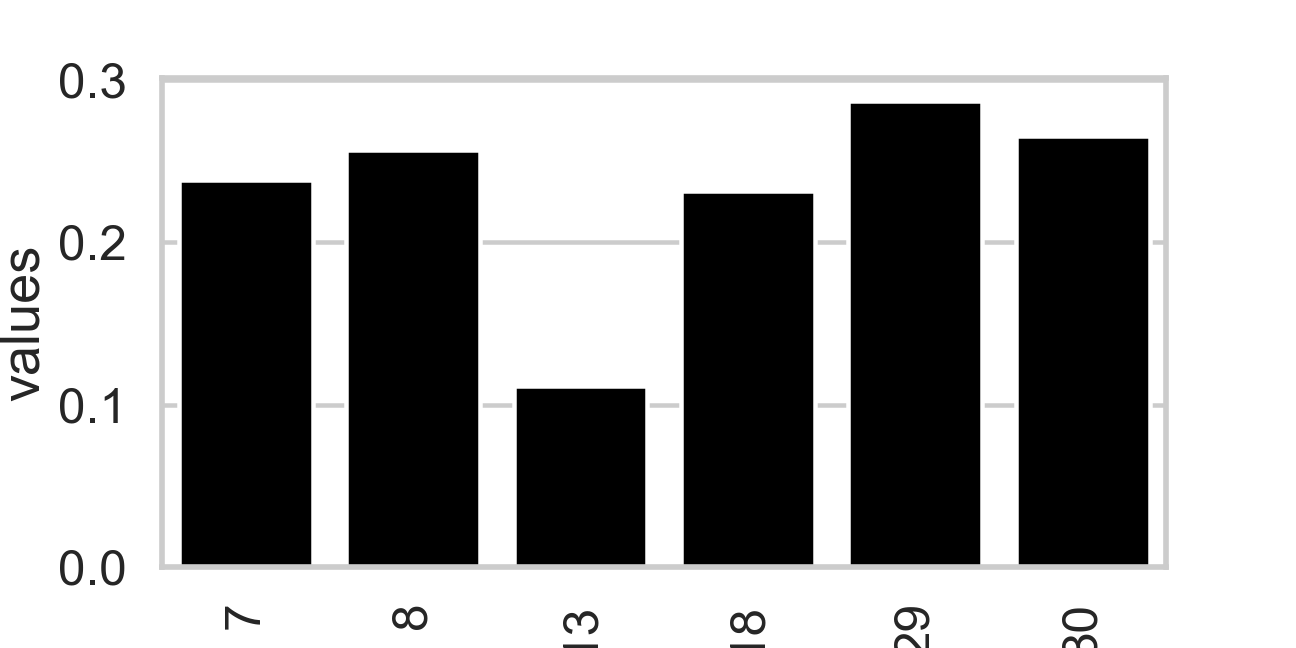

    offer_id  campaign      varietal  min_qty  discount        origin  \
6          7     March      Prosecco        6        40     Australia   
7          8     March     Espumante        6        45  South Africa   
12        13       May        Merlot        6        43         Chile   
17        18      July     Espumante        6        50        Oregon   
28        29  November  Pinot Grigio        6        87        France   
29        30  December        Malbec        6        54        France   

    past_peak  
6        True  
7       False  
12      False  
17      False  
28      False  
29      False  


In [18]:
# pca_df = pd.DataFrame({'cust_name':cust_offer_transactions.index, 'cluster_label':cluster_assignments, 'x':x, 'y':y})
# pca_df


tot_offer_participations = cust_offer_transactions.sum(axis=0)/ cust_offer_transactions.shape[0]

offers_dict = {}

for i in range(4):
    _, ax = plt.subplots(1,1,figsize=(8,4))
    cust_offer_transactions_filtered = cust_offer_transactions[cluster_id == i]
    cluster_offer_participations = cust_offer_transactions_filtered.sum(axis=0) / cust_offer_transactions_filtered.shape[0]
    difference = cluster_offer_participations - tot_offer_participations
    difference = difference[difference.values > 0]
    offers_dict[i] = difference.index
    
    sns.barplot(data=difference.reset_index().rename(columns={0:'values'}), x='offer_id', y='values', ax=ax, color=basic_palette[i])
    plt.xticks(rotation=90)
    plt.show()
    print(df_offers[df_offers.offer_id.isin(offers_dict[i])])

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
    
    The explained variance elbow point is at n_components = 3 or 4 (both have elbows, 3's is a little sharper). The total percent variance explained (cumulateve) by the first 3 principle componentes is 32. If the 4th PC is included, we get an additional 6% and if the 5th is included, we get an additional 5%. So 3 is probably adequate, but arguably, we could justify keeping 4. The 3 components definitely help to visualize the justification of 4 clusters.
    
</div>

<IPython.core.display.Javascript object>


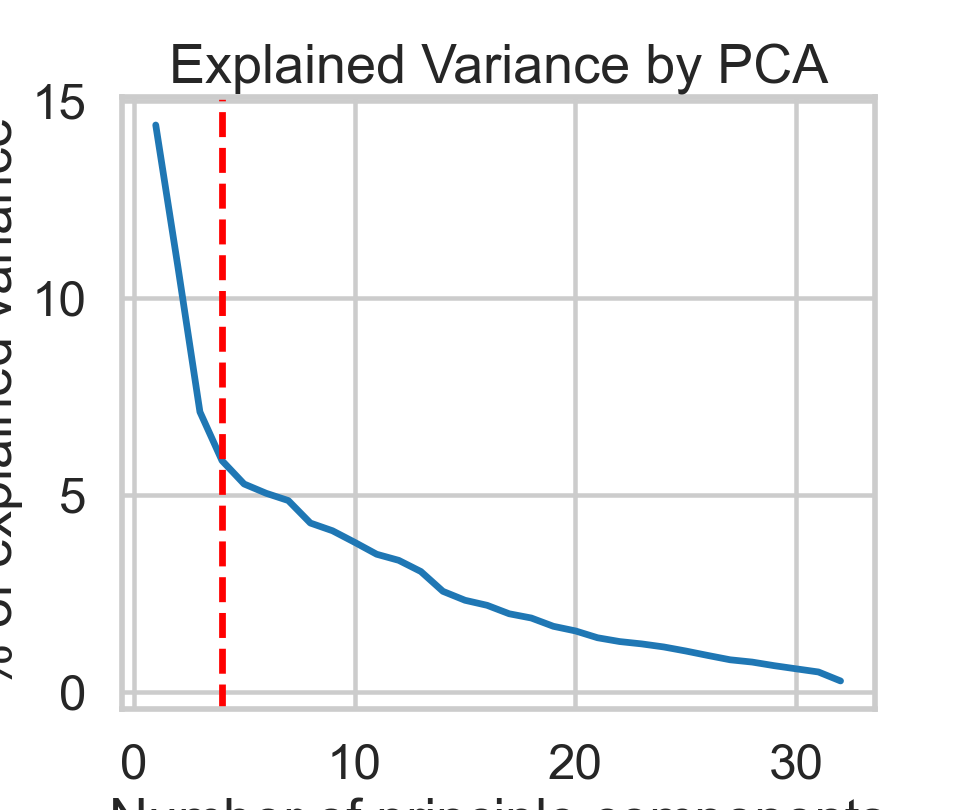

In [19]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(x_cols)

# Do the rest on your own :)
pcnt_explained = pca.explained_variance_ / sum(pca.explained_variance_)

_, ax = plt.subplots(1,1, figsize=(6,5))

sns.lineplot(x = np.arange(1,len(pcnt_explained)+1), y = pca.explained_variance_ratio_*100, ax=ax)
ax.axvline(x=4, color='red', linestyle='--')
ax.set_title('Explained Variance by PCA')
ax.set_ylabel("% of explained variance")
ax.set_xlabel("Number of principle components")
plt.show()

In [20]:
# cumulative percent variation explained by first 4 PCs
round(pca.explained_variance_ratio_.cumsum()[3]*100,2)

38.16

In [21]:
pca.explained_variance_ratio_.cumsum()*100

array([ 14.38639267,  25.186682  ,  32.29096269,  38.15711366,
        43.43029418,  48.46764529,  53.32067751,  57.60246946,
        61.68895751,  65.48329174,  68.97333601,  72.30820713,
        75.36015766,  77.90863967,  80.22998086,  82.42331845,
        84.4020501 ,  86.27296929,  87.93366913,  89.47675959,
        90.84654301,  92.11987596,  93.33348248,  94.46960878,
        95.50232446,  96.4218132 ,  97.23241455,  97.98488213,
        98.64560801,  99.22595393,  99.72681413, 100.        ])

## 4. Conclusions and next steps
### 4a. Conclusions
What can you conclude from your investigations? Make a note, formulate it as clearly as possible, and be prepared to discuss it with your mentor in your next call. 

Answered above

### 4b. Other clustering algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
    
    Affinity (14 clusters) and DBSCAN (no clusters) don't do well with this data, but Spectral and Agglomerative clustering algorithms both do fairly well.
    
</div>


In [22]:
pca_df

,cust_name,cluster_label,x,y
0,Adams,3,1.007580,0.108215
1,Allen,2,-0.287539,0.044715
2,Anderson,0,-0.392032,1.038391
3,Bailey,3,0.699477,-0.022542
4,Baker,1,0.088183,-0.471695
...,...,...,...,...
95,Williams,1,-0.151666,-0.587844
96,Wilson,3,0.688224,-0.013688
97,Wood,2,-0.551215,-0.395670
98,Wright,1,-0.489805,-0.383307


Affinity Propagation:
Estimated number of clusters: 14
Silhouette Coefficient: 0.183


<IPython.core.display.Javascript object>


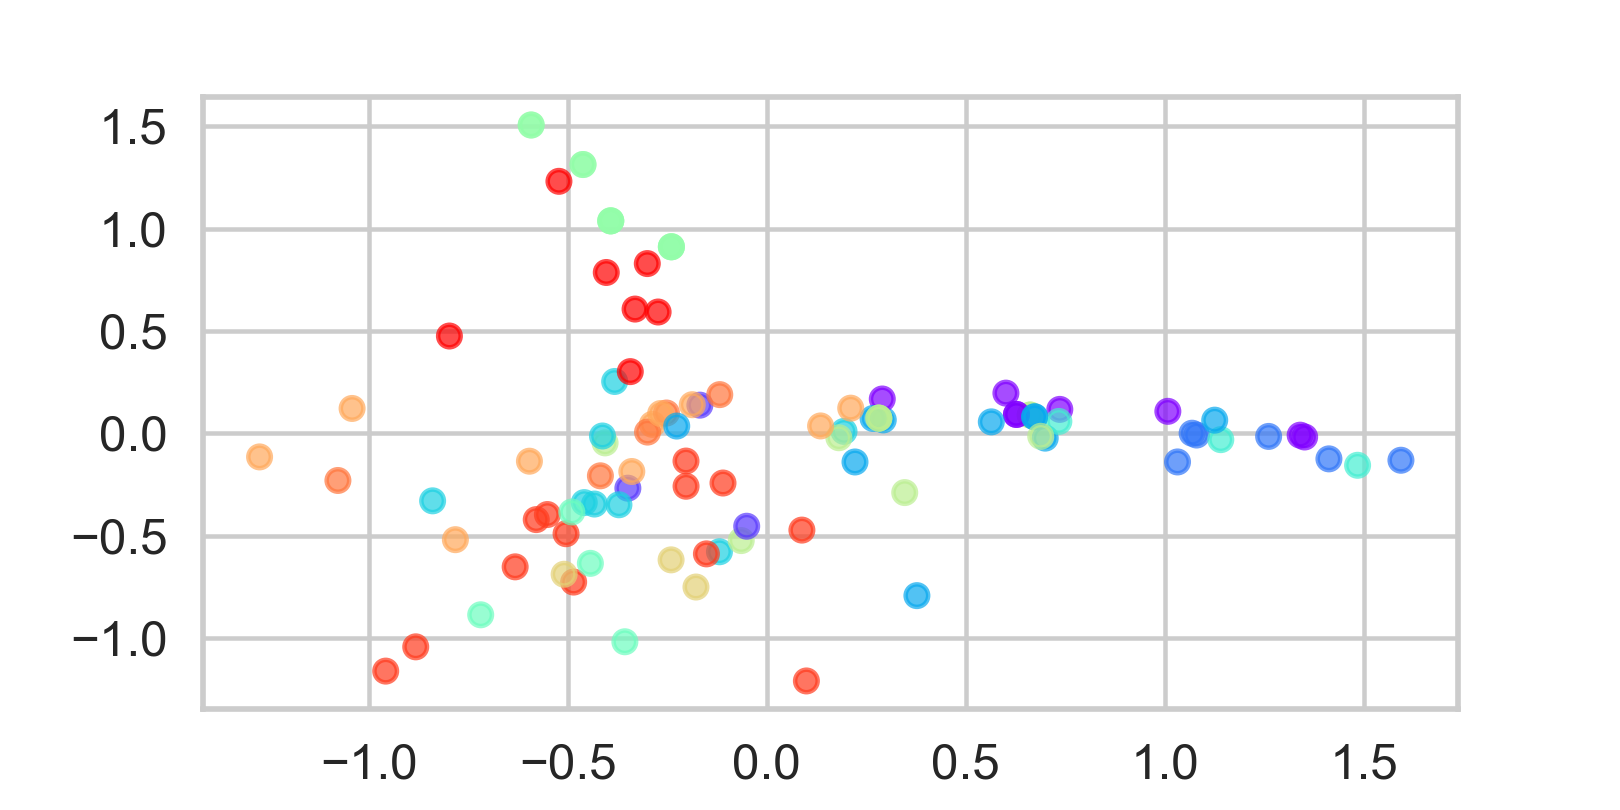

In [23]:
#Affinity Propagation
from sklearn.cluster import AffinityPropagation
from sklearn.metrics import silhouette_score

afpr = AffinityPropagation().fit(x_cols)
cluster_centers_indices = afpr.cluster_centers_indices_
afpr_labels = afpr.labels_
centers = afpr.cluster_centers_
n_clusters_ = len(cluster_centers_indices)

print("Affinity Propagation:")
print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % silhouette_score(x_cols, afpr_labels, metric='sqeuclidean'))

# Plot clusters
plt.subplots(figsize=(10,5))
plt.scatter(pca_df['x'], pca_df['y'], alpha=0.7, c=afpr_labels, cmap='rainbow', s=100)
plt.show()


Spectral Clustering:
Silhouette Coefficient: 0.119


<IPython.core.display.Javascript object>


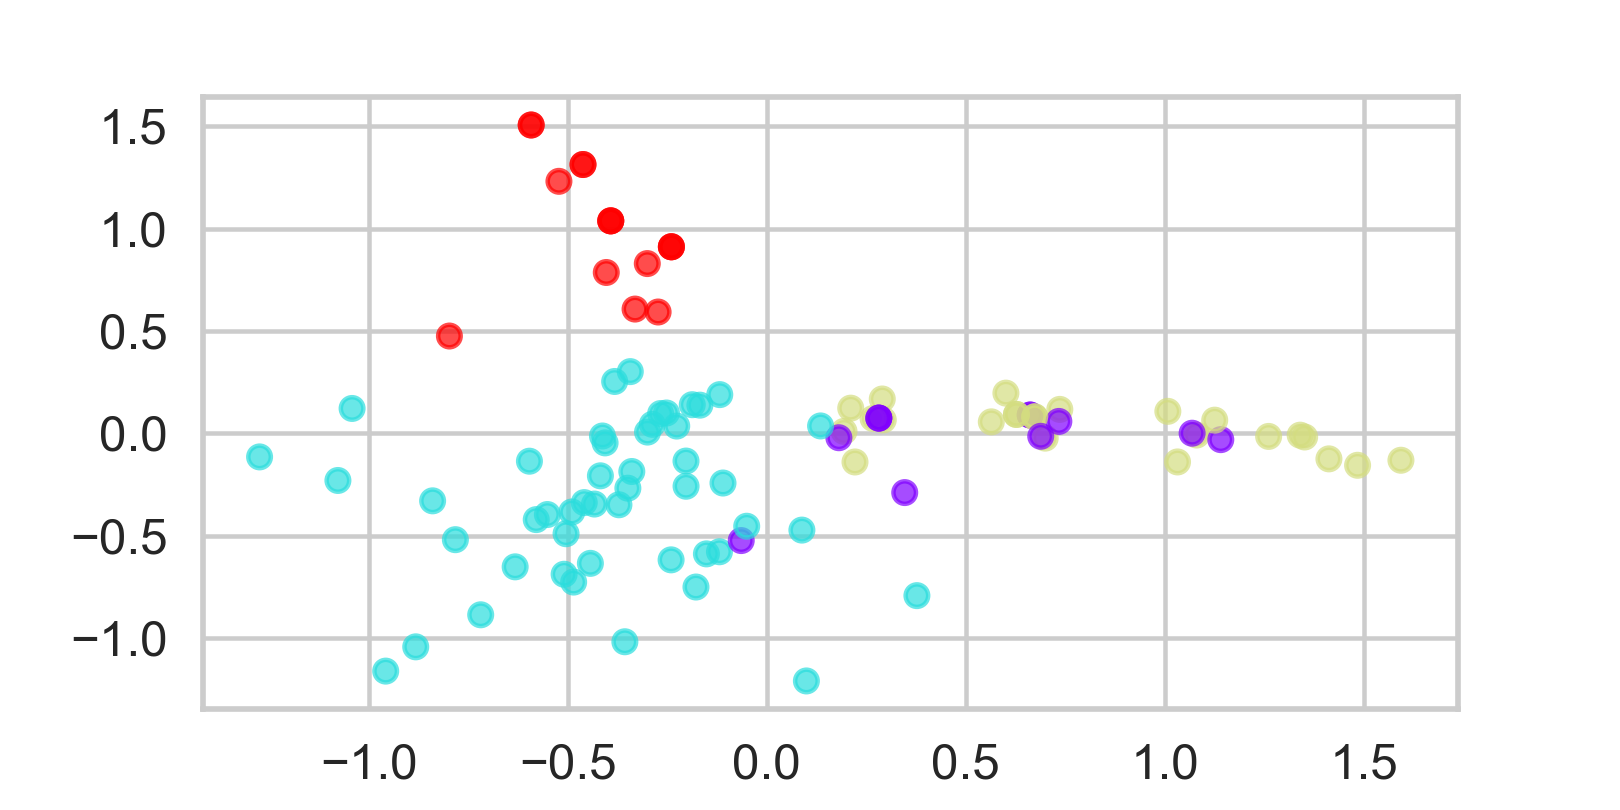

In [26]:
#Spectral Clustering
from sklearn.cluster import SpectralClustering

specc = SpectralClustering(n_clusters=4, random_state=38).fit(x_cols) #n_clusters=10 results in the highest silhouette score
specc_labels = specc.labels_

print("Spectral Clustering:")
print("Silhouette Coefficient: %0.3f"
      % silhouette_score(x_cols, specc_labels, metric='sqeuclidean'))

# Plot clusters
plt.subplots(figsize=(10,5))
plt.scatter(pca_df['x'], pca_df['y'], alpha=0.7, c=specc_labels, cmap='rainbow', s=100)
plt.show()

Agglomerative Clustering:
Silhouette Coefficient: 0.196


<IPython.core.display.Javascript object>


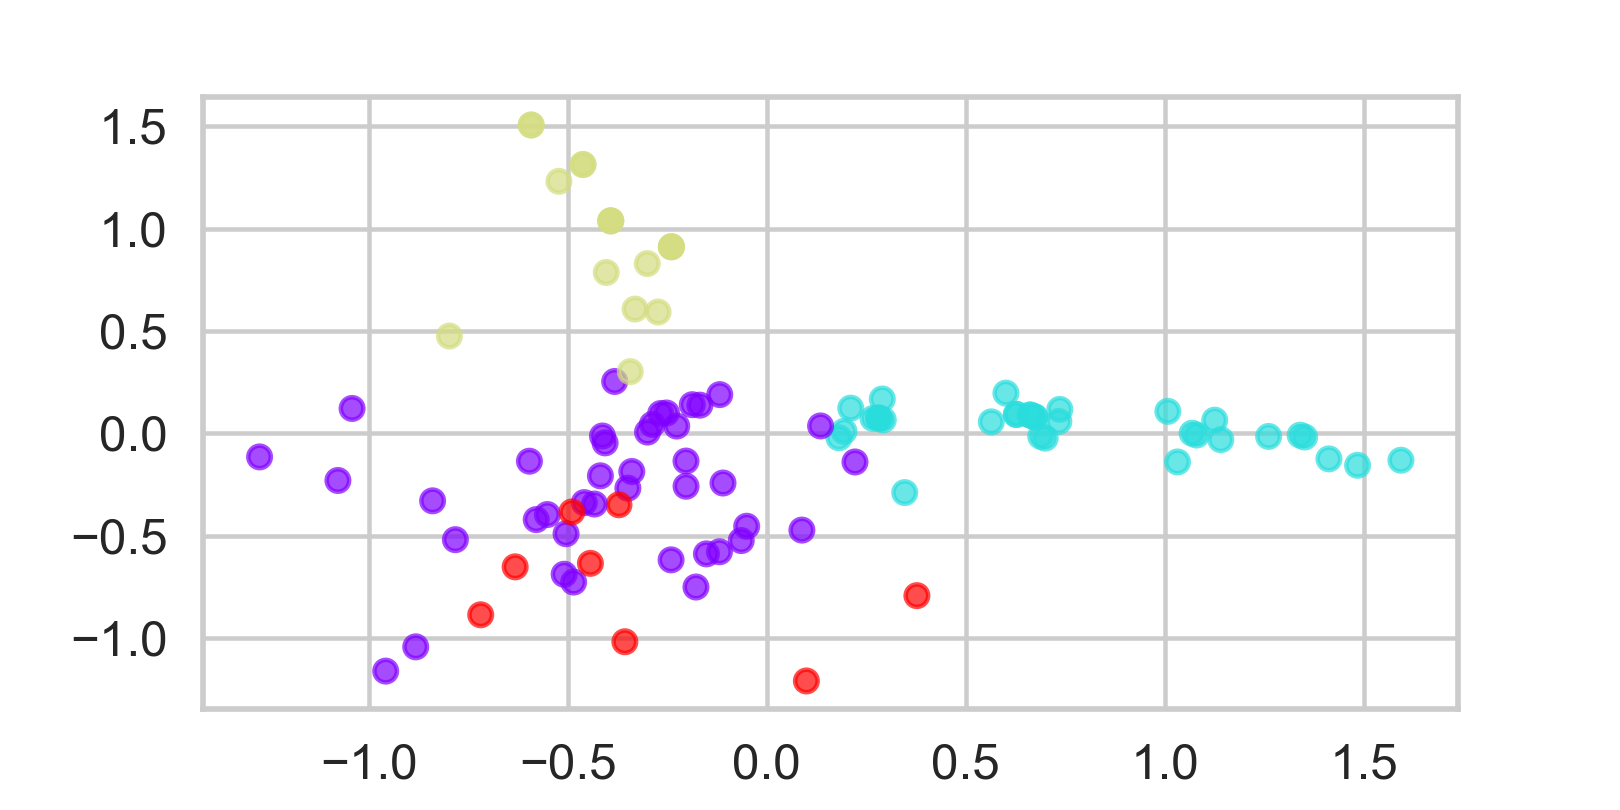

In [27]:
#Agglomerative Clustering
from sklearn.cluster import AgglomerativeClustering

agc = AgglomerativeClustering(4).fit(x_cols) # results in the highest silhouette coefficient
agc_labels = agc.labels_

print("Agglomerative Clustering:")
print("Silhouette Coefficient: %0.3f"
     % silhouette_score(x_cols, agc_labels, metric='sqeuclidean'))

# Plot clusters
plt.subplots(figsize=(10,5))
plt.scatter(pca_df['x'], pca_df['y'], alpha=0.7, c=agc_labels, cmap='rainbow', s=100)
plt.show()

DBSCAN:
Silhouette Coefficient: NA
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1]


<IPython.core.display.Javascript object>


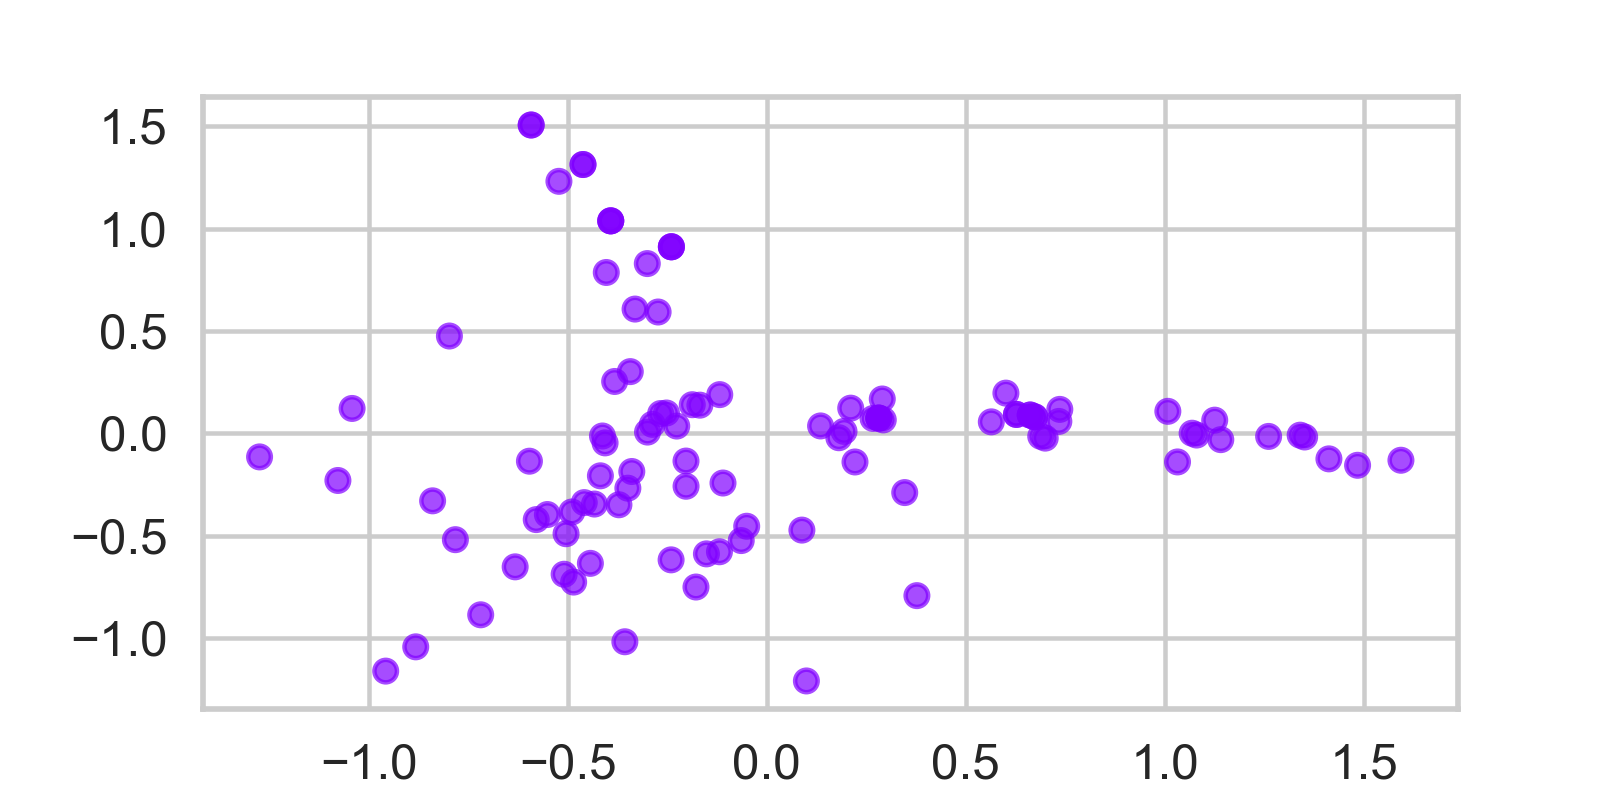

In [31]:
#DBSCAN
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.1,min_samples=20).fit(x_cols)
db_labels = dbscan.labels_

print("DBSCAN:")
print("Silhouette Coefficient: NA"
     #% silhouette_score(x_cols, db_labels, metric='sqeuclidean')
     )

print(db_labels)
# Plot clusters
plt.subplots(figsize=(10,5))
plt.scatter(pca_df['x'], pca_df['y'], alpha=0.7, c=db_labels, cmap='rainbow', s=100)
plt.show()